# Prediction of Lorenz System Using Reservoir Computing
Apr 18, 2019. Guorui Shen, guorui233@outlook.com

This notebook is intended to predict Lorenz system, using reservoir computing techniques. Sturcture of adopted network is
\begin{eqnarray}
r(t+\Delta t) = (1-\alpha)\cdot r(t) + \alpha\cdot\text{tanh}\big(r(t)\cdot W_r^r + u(t)\cdot W_{in}^r + b_{in}\big),\\
y(t+\Delta t) = r(t+\Delta t)\cdot W_r^{out} + u(t)\cdot W_{in}^{out} + b_{out},
\end{eqnarray}
where $u(t), r(t), y(t), b_{in}, b_{out}$ are all row vectors, only $W_i^{out}, i=r, in,$ and $b_{out}$ are to be trained via Ridge regression, the remaning unknown weights and biases are assigned random values and no update.

Feature and label are chosen as 
\begin{eqnarray}
u(t) = \Big(x_1(t),x_2(t)\Big),\\
y(t+\Delta t) = \Big(x_3(t+\Delta t)\Big),
\end{eqnarray}
respectively, where $\Big(x_1(t), x_2(t), x_3(t)\Big)$ are state of Lorenz system
\begin{eqnarray}
\begin{aligned}
&\frac{dx_1}{dt}=\sigma(x_2-x_1),\\
&\frac{dx_2}{dt}=x_1(\rho-x_3)-x_2,\\
&\frac{dx_3}{dt}=x_1x_2-\beta x_3.
\end{aligned}
\end{eqnarray}

In [1]:
from reservoir import Reservoir
import scipy.io as sio
import numpy as np
from scipy import sparse
from matplotlib import pyplot as plt

In [2]:
lrz = sio.loadmat('Lorenz.mat')
print len(lrz['states']), len(lrz['states'][0])

6000 3


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,u't')

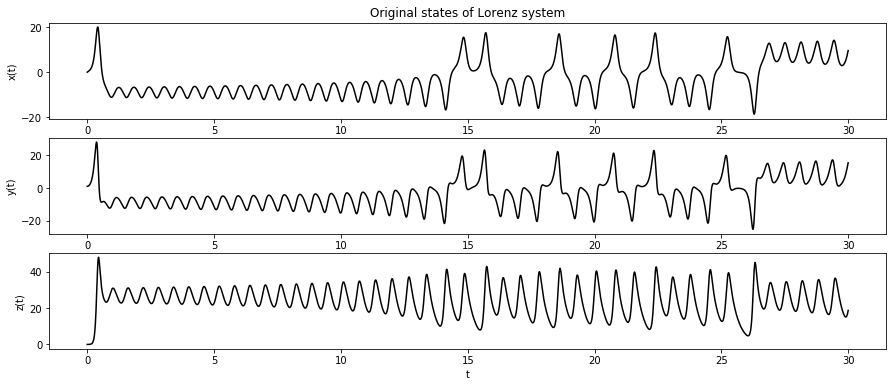

In [3]:
ylabel = ['x(t)', 'y(t)', 'z(t)']
plt.figure(figsize=(15, 6))
plt.subplot(311)
plt.title('Original states of Lorenz system')
for i in range(3):
    plt.subplot(311+i)
    plt.plot(lrz['t'][0], lrz['states'][:, i], 'k-')
    plt.ylabel(ylabel[i])
plt.xlabel('t')

In [4]:
# parameters for choosing training data
train_end = 3500
num_pre_steps = 1000 # forward predictions steps
num_init = 500
train_start = 1000  # discard first "train_start" steps

# training data
features = lrz['states'][train_start:train_end, 0:2]
labels = lrz['states'][train_start+1:train_end+1, 2:3]
print labels.shape

(2500, 1)


In [5]:
np.random.seed(9)
# seeds tested from 1 to 20, (seed, error), (9,5.9), (3,13) (1,33) (2,314)

In [6]:
# parameters of networks
dim_in = len(features[0]) # dimension of input
dim_r = 300               # dimension of reservoir
dim_out = len(labels[0])  # dimension of output
lam = .00001 # regression parameter

In [7]:
# build a reservoir model for Lorenz system
Lorenz_reservoir =  Reservoir(dim_in, dim_r, dim_out, alpha=.3, spectral_radius=1.25)

# train the model
Lorenz_reservoir.train(features, labels, num_init, lam)

# predict future states
u = lrz['states'][train_end, 0:2]
states_predict = np.zeros((num_pre_steps, dim_out))
for t in range(num_pre_steps):
    states_predict[t, :] = Lorenz_reservoir.predict(lrz['states'][train_end+t, 0:2])

Prediction error: 5.969737295056602


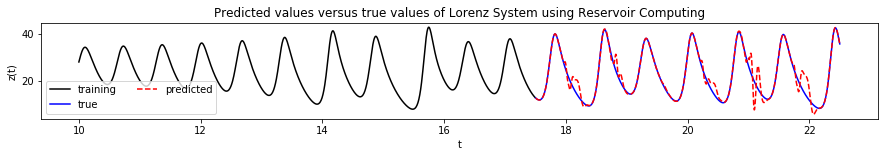

In [8]:
# visualize prediction results
t_test = lrz['t'][0][train_end+1:train_end+1+num_pre_steps]
states_test = lrz['states'][train_end+1:train_end+1+num_pre_steps, :]

t_train = lrz['t'][0][train_end-int(1.5*num_pre_steps):train_end]
states_train = lrz['states'][train_end-int(1.5*num_pre_steps):train_end, :]
print "Prediction error:",sum(np.square(states_predict[:,0] - states_test[:, 2]))/num_pre_steps

plt.figure(figsize=(15, 6))
plt.subplot(311)
plt.title('Predicted values versus true values of Lorenz System using Reservoir Computing')
plt.plot(t_train, states_train[:, 2], 'k-', t_test, states_test[:, 2], 'b-', t_test, states_predict, 'r--')
plt.ylabel(ylabel[i])
plt.xlabel('t')
plt.legend(["training", "true", "predicted"], loc = 0, ncol = 2)